In [634]:
import spacy
# python -m spacy download en_core_web_sm
# python -m spacy download pl_core_news_sm
import re
import tarfile
import os
import matplotlib.pyplot as plt
import numpy as np
import regex
import pandas as pd
import morfeusz2
from elasticsearch_dsl import *
from elasticsearch_dsl import query
from elasticsearch import *
from elasticsearch.helpers import *

import os
import pickle

import spacy
from collections import Counter
from spacy.tokenizer import *
import string
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
import pandas as pd
import time


1. Make sure the texts in the corpus does not contain HTML code.
2. Use SpaCy [tokenizer API](https://spacy.io/api/tokenizer) to tokenize the text from the cleaned law corpus.
3. Compute **frequency list** for each of the processed files.
4. Aggregate the result to obtain one global frequency list.
5. Reject all entries that are shorter than 2 characters or contain non-letter characters (make sure to include Polish
   diacritics).
6. Make a plot in a logarithmic scale (for X and Y):
   1. X-axis should contain the **rank** of a term, meaning the first rank belongs to the term with the highest number of
      occurrences; the terms with the same number of occurrences should be ordered by their name,
   2. Y-axis should contain the **number of occurrences** of the term with given rank.

In [314]:
nlp = spacy.load("pl_core_news_sm")
tokenizer = Tokenizer(nlp.vocab)


In [601]:
text = "Ala ma-kota\ni psa"
text = text.translate(str.maketrans('', '', string.punctuation))
print(text)

Ala makota
i psa


In [325]:

file_tokens = {}

i = 0
path="../data/ustawy"
for filename in os.listdir(path):
    with open(os.path.join(path, filename), 'r',encoding='utf-8') as f: # open in readonly mode
        text = f.read()
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = text.lower()
        text = regex.sub(r'\s+', ' ',text)


        doc = tokenizer(text)
        words = [token.text for token in doc if token.is_stop != True and token.is_punct != True and (len(token.text) >1) and token.is_alpha and not token.is_digit ]

        file_tokens[f.name] = words
        word_freq = Counter(words)
        i+=1
        if i % 200 == 0:
            print(i)
    

200
400
600
800
1000


In [326]:
word_freq ={}
for filename, tokens in file_tokens.items():
    word_freq[filename] = Counter(tokens)

In [327]:
word_freq_total = Counter({})
for counting in word_freq.values():
    word_freq_total.update(counting)


In [328]:
word_freq_total.most_common(5)

[('art', 82771),
 ('ust', 53356),
 ('poz', 45028),
 ('nr', 44941),
 ('mowa', 28782)]

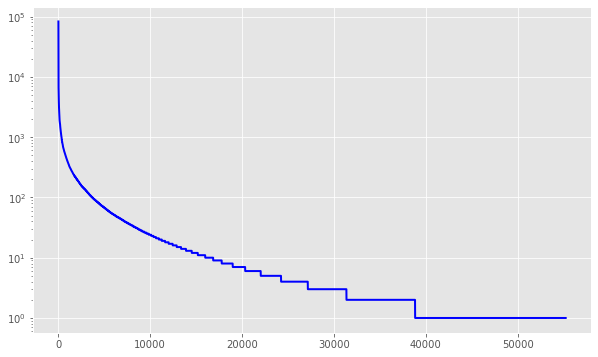

In [329]:
freq = [freq for (_,freq) in word_freq_total.most_common()]
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.plot(range(1,len(word_freq_total)+1),freq, color='blue', lw=2)

ax.set_yscale('log')

plt.show()


7. Install [Morfeusz](http://morfeusz.sgjp.pl/download/) (Binding dla Pythona) and use it to find all words that do not
  appear in that dictionary.


In [340]:
from morfeusz2 import *
#Obiekt utworzony bez podawania parametrów konstruktora będzie używał domyślnego słownika SGJP i domyślnych ustawień opcji.
morf = Morfeusz()

not_found = {}
for (token,freq) in word_freq_total.most_common():
#     print('!'+token+'!',(morf.analyse(token)))
    if 'ign' in (morf.analyse(token))[0][2]:
#         print(freq,token)
        not_found[token] =freq
        
        

In [569]:
morf.analyse("piws")

[(0, 1, ('piws', 'piws', 'ign', [], []))]

8. Find 30 words with the highest ranks that do not belong to the dictionary.

In [332]:
counter = Counter(not_found).most_common(30)
counter

[('poz', 45028),
 ('dzu', 5766),
 ('późn', 1065),
 ('str', 514),
 ('gmo', 298),
 ('dzurz', 218),
 ('sww', 213),
 ('skw', 193),
 ('ex', 169),
 ('ike', 162),
 ('jt', 120),
 ('remediacji', 119),
 ('zm', 112),
 ('rozdz', 102),
 ('ure', 101),
 ('itp', 97),
 ('kn', 95),
 ('uke', 92),
 ('np', 85),
 ('cn', 82),
 ('pkwiu', 81),
 ('udt', 76),
 ('biobójczych', 63),
 ('bswsg', 63),
 ('bswp', 57),
 ('phs', 53),
 ('mgo', 41),
 ('fep', 41),
 ('utk', 39),
 ('frd', 36)]

9. Find 30 random words (i.e. shuffle the words) with 5 occurrences that do not belong to the dictionary.

In [356]:
import random
freq_5 = [token for (token,freq) in not_found.items() if freq==5 ]
random.shuffle(freq_5)
print(freq_5[0:30])


['fd', 'swine', 'rci', 'denitracyjne', 'wlkp', 'odbieralnice', 'kilogramówmetr', 'inci', 'betezda', 'teryto', 'rr', 'zawart', 'najmnie', 'rialnego', 'aiiibiiiciii', 'instrumen', 'łips', 'winopochodne', 'msr', 'schetyna', 'agave', 'wapnio', 'cz', 'odgazowywacze', 'regazyfikacyjnego', 'ijk', 'ym', 'chelatującym', 'iiin', 'państwamistronami']


# 10
10. Use Levenshtein distance and the frequency list, to determine the most probable correction of the words from
   lists defined in points 8 and 9. (**Note**: You don't have to apply the distance directly. Any method that is more efficient than scanning the
   dictionary will be appreciated.)

In [419]:
morf = Morfeusz()
analysis_result = morf.analyse("Ala je kota")

print(analysis_result)


[(0, 1, ('Ala', 'Ala', 'subst:sg:nom:f', ['imię'], [])), (0, 1, ('Ala', 'Al', 'subst:sg:gen.acc:m1', ['imię'], [])), (0, 1, ('Ala', 'Alo', 'subst:sg:gen.acc:m1', ['imię'], [])), (1, 2, ('je', 'on:S', 'ppron3:pl:acc:m2.m3.f.n:ter:akc.nakc:npraep', [], [])), (1, 2, ('je', 'on:S', 'ppron3:sg:acc:n:ter:akc.nakc:npraep', [], [])), (1, 2, ('je', 'jeść', 'fin:sg:ter:imperf', [], [])), (2, 3, ('kota', 'kota', 'subst:sg:nom:f', ['nazwa_pospolita'], [])), (2, 3, ('kota', 'kot:Sm1', 'subst:sg:gen.acc:m1', ['nazwa_pospolita'], ['pot.,środ.'])), (2, 3, ('kota', 'kot:Sm2', 'subst:sg:gen.acc:m2', ['nazwa_pospolita'], []))]


In [622]:
filename = '../data/sgjp-20211031.tab'
sjp =pd.read_csv(filename,skiprows=29,usecols=[0,1],header=None,delim_whitespace='\t')[1]

sjp = set(sjp)

In [652]:
def find_corrections(words):
    start = time.time()
    suggestions = {}

    i = 0
    for word in words: # words with 5 ocurrences
        suggestions[word] = []
        for dic in sjp:
            if Levenshtein.distance(word,dic) <2:
                    
                suggestions[word].append(dic)
        i+=1
        if i%5==0:
            print(i)

    end = time.time() - start
    print("total time", end)
    return suggestions

def print_corrections(words):
    for k,v in find_corrections(words).items():
        print(k, "--->",v)

In [653]:
print_corrections(freq_5)

5
10
15
20
25
30
35
40
45
50
total time 13.521697521209717
fd ---> ['od', 'fe', 'fu', 'ud', 'fa', 'fi', 'id', 'Ed']
swine ---> []
rci ---> ['ci']
denitracyjne ---> []
wlkp ---> []
odbieralnice ---> []
kilogramówmetr ---> []
inci ---> ['Vinci']
betezda ---> []
teryto ---> []
rr ---> ['frr', 'ar', 'ro', 'wrr', 'prr', 'drr', 'er', 'brr', 'rh', 'nr', 'dr', 're']
zawart ---> []
najmnie ---> ['najemnie']
rialnego ---> []
aiiibiiiciii ---> []
instrumen ---> ['instrument']
łips ---> ['gips', 'tips', 'mips']
winopochodne ---> []
msr ---> ['mur', 'mir', 'mgr', 'mor', 'mjr', 'mór']
schetyna ---> []
agave ---> ['agape']
wapnio ---> ['wapno', 'wapnić']
cz ---> ['acz', 'ci', 'ck', 'bz', 'ce', 'cez', 'oz', 'az']
odgazowywacze ---> []
regazyfikacyjnego ---> []
ijk ---> ['isk']
ym ---> ['yhm', 'um', 'hm', 'em', 'om', 'dym', 'cym', 'im', 'km']
chelatującym ---> []
iiin ---> ['iii']
państwamistronami ---> []
eudravigilance ---> []
ami ---> ['mi', 'ali', 'amia', 'rami', 'amid', 'ćmi', 'kami']
ppkt ---> ['

In [654]:
# print(suggestions)
top_30 = [token for (token,_) in counter]

print_corrections(top_30)


5
10
15
20
25
30
total time 7.601879119873047
poz ---> ['pot', 'płoz', 'pod', 'paz', 'po', 'oz']
dzu ---> ['dziu', 'szu']
późn ---> ['późny', 'późno']
str ---> ['sto', 'itr', 'ster', 'syr', 'ser', 'styr', 'star']
gmo ---> ['śmo', 'go']
dzurz ---> []
sww ---> ['suw', 'www']
skw ---> ['suw', 'ski', 'ska']
ex ---> ['ee', 'en', 'em', 'eł', 'eń', 'et', 'ej', 'er', 'eh', 'eś', 'el', 'Rex', 'sex', 'e']
ike ---> ['iże', 'Nike']
jt ---> ['ut', 'jut', 'ja', 'et', 'jot', 'ot']
remediacji ---> []
zm ---> ['um', 'hm', 'em', 'om', 'izm', 'im', 'km']
rozdz ---> []
ure ---> ['öre', 'ura', 're']
itp ---> ['ftp', 'itr']
kn ---> ['ka', 'en', 'in', 'k', 'kb', 'km', 'ki']
uke ---> []
np ---> ['bp', 'nu', 'up', 'nr']
cn ---> ['cyn', 'cny', 'cna', 'en', 'in', 'ci', 'ck', 'ce', 'cno']
pkwiu ---> []
udt ---> ['ut', 'ud', 'udo']
biobójczych ---> []
bswsg ---> []
bswp ---> []
phs ---> ['phu', 'pąs', 'phy']
mgo ---> ['mgło', 'mgr', 'ego', 'go']
fep ---> ['sep', 'fez', 'ftp', 'lep', 'fe', 'fes']
utk ---> ['ut', 'u

# ELASTICSEARCH

11. Load [SGJP dictionary](http://morfeusz.sgjp.pl/download/) (Słownik SGJP dane tekstowe) to ElasticSearch (one document for each form) 
   and use fuzzy matching to obtain the possible
   corrections of the 30 words with 5 occurrences that do not belong to the dictionary.

In [570]:
es = Elasticsearch("http://localhost:9200")
print(es.info())

connections.add_connection('python_client', es)
connections.create_connection(hosts=['localhost'])


{'name': 'x-dell', 'cluster_name': 'elasticsearch', 'cluster_uuid': 'hrJwCHZtSGm_1kBHAztvag', 'version': {'number': '7.10.1', 'build_flavor': 'default', 'build_type': 'deb', 'build_hash': '1c34507e66d7db1211f66f3513706fdf548736aa', 'build_date': '2020-12-05T01:00:33.671820Z', 'build_snapshot': False, 'lucene_version': '8.7.0', 'minimum_wire_compatibility_version': '6.8.0', 'minimum_index_compatibility_version': '6.0.0-beta1'}, 'tagline': 'You Know, for Search'}


<Elasticsearch([{'host': 'localhost'}])>

In [589]:
synonym = token_filter('my_name', type='synonym',
                       synonyms =
                       ["kpk => kodeks postępowania karnego",
                        "kpc => kodeks postępowania cywilnego",
                        "kk => kodeks karny",
                        "kc => kodeks cywilny"
                       ])

my_analyzer = analyzer('my_analyzer',
    tokenizer=tokenizer('standard'),
    filter=["lowercase",synonym,"morfologik_stem"]
)


class Ustawa(Document):
    title = Text()
    created_at = Integer()
    content = Text(analyzer=my_analyzer)
    
    class Index:
        name = 'ustawa'
        
        

Ustawa.init()

iterations = 0
path="../data/ustawy"
for filename in os.listdir(path):
    with open(os.path.join(path, filename), 'r',encoding='utf-8') as f: # open in readonly mode
        
        year = int(re.search(r'.*\/([^\/]{4})',f.name).group(1))
        first = Ustawa(title=f.name,content=f.read(),created_at = year)
        
        first.save(using=es)
        iterations+=1

In [591]:
filename = '../data/sgjp-20211031.tab'
sjp =pd.read_csv(filename,skiprows=29,usecols=[0,1],header=None,delim_whitespace='\t')[1]

sjp = set(sjp)

In [590]:

# def gendata():
#     mywords = ['kot', 'mysz', 'baz']
#     for word in mywords:
#         yield {
#             "_index": "mywords1",
#             "word": word,
#         }

# bulk(es, gendata(),request_timeout=10000)

In [592]:
def gendata():
    i=0
    for word in sjp:
        if i%300000 ==0:
            print(i)
        i+=1
        yield {
            "_index": "sjp",
            "word": word,
        }
                

bulk(es, gendata(),request_timeout=10000 )

0
300000


(383709, [])

In [665]:
def get_corrections(myword,myindex):
    result =es.search(index=myindex,
       query ={
            "fuzzy": {
                "word": {
                "value": myword,
                "fuzziness": 1
                }
            }
        }
    )
    hits = result['hits']['hits']


    hits_number = len(hits)

    # print(hits_number)

    suggestions = [i['_source']['word'] for i in hits]
    # print(suggestions)
    return suggestions


print(get_corrections('mysz','sjp'))


def get_corrections_if_needed(word,index):
    corrections = get_corrections(word,index)

    if word in corrections:
        return ["Word belongs to the dictionary"]
    else:
        return corrections
    


print(get_corrections_if_needed('mysz','sjp'))

['misz-masz', 'mysz', 'kysz', 'mysi', 'wysz', 'mesz', 'myszy', 'MSZ']
['Word belongs to the dictionary']


In [666]:
start = time.time()

for word in freq_5:
    corrections = get_corrections_if_needed(word,'sjp')
    print(word, '-->', corrections)
print(f'Total time={time.time()-start}')


fd --> ['Wygoda:Sf~od~ód', 'Kłoda:Sf~od~ód', 'Loda:Sf~od~ód', 'fu', 'od', 'ud', 'fa', 'fi', 'fe', 'FC']
swine --> []
rci --> ['PCI', 'RAI', 'RCA', 'ci', 'Gać:Sf~ci', 'imć:Sm1~ci', 'Got:Sm1~ci', 'Galata:Sm1~ci', 'Kopyść:Sf~ci', 'Zbylut:Sm1~ci~towie']
denitracyjne --> []
wlkp --> []
odbieralnice --> []
kilogramówmetr --> []
inci --> ['Vinci']
betezda --> []
teryto --> []
rr --> ['ro-ro', 'BR', 'wrr', 'RE', 'prr', 'RdR', 'drr', 'Rh', 'ROR', 'ro']
zawart --> ['Zawrat', 'Zawarta']
najmnie --> ['najemnie']
rialnego --> []
aiiibiiiciii --> []
instrumen --> ['instrument']
łips --> ['gips', 'tips', 'mips']
winopochodne --> []
msr --> ['MSP', 'mor', 'mur', 'MSZ', 'mir', 'mgr', 'MSW', 'mjr', 'mór', 'ASR']
schetyna --> []
agave --> ['agape']
wapnio --> ['Wapnik', 'wapnić', 'Wapno', 'wapno']
cz --> ['cza-cza', 'LZ', 'BZ', 'CV', 'acz', 'ci', 'CZD', 'UZ', 'ck', 'bz']
odgazowywacze --> []
regazyfikacyjnego --> []
ijk --> ['isk']
ym --> ['yo-yo', 'hm', 'UM', 'yhm', 'AM', 'DM', 'um', 'im', 'my', 'dym']


In [667]:
start = time.time()

for word in top_30:
    corrections = get_corrections_if_needed(word,'sjp')
    print(word, '-->', corrections)
print(f'Total time={time.time()-start}')

poz --> ['POW', 'TOZ', 'ZOZ', 'Pot', 'płoz', 'pod', 'paz', 'Poe', 'pot', 'PO']
dzu --> ['szu', 'dziu', 'PZU', 'Zyga:Sm1~dzy', 'dżu-dżitsu', 'łubu-du']
późn --> ['późny', 'późno', 'Późna']
str --> ['Star', 'itr', 'sto', 'STAR', 'ster', 'syr', 'ser', 'styr', 'star', 'SOR']
gmo --> ['WMO', 'GMC', 'śmo', 'MO', 'go', 'GM', 'Faure:Sm1~go', 'Wilde:Sm1~go', 'Hauke:Sm1~go', 'go-cart']
dzurz --> []
sww --> ['suw', 'WWW', 'WSW', 'www', 'SW']
skw --> ['suw', 'PKW', 'ska', 'SKS', 'ski', 'UKW', 'SW']
ex --> ['eł', 'eń', 'eh', 'et', 'ej', 'EP', 'er', 'ee', 'eś', 'en']
ike --> ['IKEA', 'iże', 'IDE', 'Nike', 'Ikea', 'KE']
jt --> ['jo-jo', 'ja', 'MT', 'et', 'ut', 'jut', 'jot', 'ot', 'Sobota:Sf~ot', 'Sobota:Sf~ót']
remediacji --> []
zm --> ['powypasać:Vp~am~zę', 'pasać:Vi~am~zę', 'hm', 'UM', 'AM', 'DM', 'um', 'im', 'ZWM', 'ZK']
rozdz --> []
ure --> ['öre', 'Uri', 'URM', 'URL', 'Urle', 'URz', 'ura', 'BRE', 'RE', 'UE']
itp --> ['UTP', 'ITI', 'itr', 'Ita', 'MTP', 'FTP', 'DTP', 'ftp', 'ATP', 'IP']
kn --> ['w

In [436]:
import Levenshtein

print(Levenshtein.distance("AA","BA!"))

2


In [661]:
freq_5

['fd',
 'swine',
 'rci',
 'denitracyjne',
 'wlkp',
 'odbieralnice',
 'kilogramówmetr',
 'inci',
 'betezda',
 'teryto',
 'rr',
 'zawart',
 'najmnie',
 'rialnego',
 'aiiibiiiciii',
 'instrumen',
 'łips',
 'winopochodne',
 'msr',
 'schetyna',
 'agave',
 'wapnio',
 'cz',
 'odgazowywacze',
 'regazyfikacyjnego',
 'ijk',
 'ym',
 'chelatującym',
 'iiin',
 'państwamistronami',
 'eudravigilance',
 'ami',
 'ppkt',
 'kpwig',
 'nitracyjne',
 'ponitracyjnego',
 'jed',
 'ośc',
 'contagious',
 'nfośigw',
 'sposb',
 'xxxixxliv',
 'ivn',
 'vista',
 'próbobiorców',
 'shigella',
 'urt',
 'tzn',
 'sędziakomisarz',
 'glinowo',
 'gj']

In [554]:

s = Search(using=es, index="ustawa").query("match_all")[:3000].execute()
ids = [x.meta.id for x in s]

amount=0
for id in ids:
    s = es.termvectors(index="ustawa", fields="content", id =id,field_statistics=True)
    print(s['term_vectors']['content']['terms'])
    try:
        amount += s['term_vectors']['content']['terms']['ustawa']['term_freq']
    except KeyError:
        pass
    break
print(amount)


{'1': {'term_freq': 59, 'tokens': [{'position': 36, 'start_offset': 487, 'end_offset': 488}, {'position': 37, 'start_offset': 490, 'end_offset': 491}, {'position': 106, 'start_offset': 1013, 'end_offset': 1014}, {'position': 170, 'start_offset': 1700, 'end_offset': 1701}, {'position': 217, 'start_offset': 2077, 'end_offset': 2078}, {'position': 230, 'start_offset': 2249, 'end_offset': 2250}, {'position': 246, 'start_offset': 2382, 'end_offset': 2383}, {'position': 294, 'start_offset': 2742, 'end_offset': 2743}, {'position': 323, 'start_offset': 2964, 'end_offset': 2965}, {'position': 334, 'start_offset': 3030, 'end_offset': 3031}, {'position': 336, 'start_offset': 3036, 'end_offset': 3037}, {'position': 348, 'start_offset': 3104, 'end_offset': 3105}, {'position': 381, 'start_offset': 3313, 'end_offset': 3314}, {'position': 409, 'start_offset': 3509, 'end_offset': 3510}, {'position': 482, 'start_offset': 3888, 'end_offset': 3889}, {'position': 503, 'start_offset': 4018, 'end_offset': 40

12. Compare the results of your algorithm and output of ES. 

13. Draw conclusions regarding:
   * the distribution of words in the corpus,
   * the number of true misspellings vs. the number of unknown words,
   * the performance of your method compared to ElasticSearch,
   * the results provided by your method compared to ElasticSearch,
   * the validity of the obtained corrections.